In [52]:
import pyiqa
models = pyiqa.list_models() 


We need to get 
 - Universal Image quality metric
 - Gradient Magnitude Similarity metric 


In [39]:
 
import numpy as np
from scipy import ndimage 
from skimage.metrics import structural_similarity
from skimage.util import img_as_float
from skimage import filters
import warnings
warnings.filterwarnings('ignore')
import cv2

def ssim(img1, img2, ws=8) -> float:
    """Structural Similarity Index (2004)
        output: float - SSIM in [0,1] (typically, can be outside for very dissimilar images, clipped)
    """
    img1 = img_as_float(img1)
    img2 = img_as_float(img2)
    if img1.ndim == 3:
        img1 = np.mean(img1, axis=2)
    if img2.ndim == 3:
        img2 = np.mean(img2, axis=2)
    ws = min(ws, img1.shape[0]//2, img1.shape[1]//2)
    if ws < 2:
        ws = 2
    # Ensure window size is odd (required by skimage.metrics.structural_similarity)
    if ws % 2 == 0:
        ws += 1
    ssim_index = structural_similarity(img1, img2, win_size=ws, data_range=img1.max() - img1.min())
    # ssim_index = feature.structural_similarity(img1, img2, win_size=ws, data_range=img1.max() - img1.min())  return float(np.clip(ssim_index, 0, 1))
    return float(np.clip(ssim_index, 0, 1))

def psnr(img1, img2) -> float:
    """Peak Signal-to-Noise Ratio (PSNR)
        output: float - PSNR in dB, higher is better
    """
    img1 = img_as_float(img1)
    img2 = img_as_float(img2)
    if img1.ndim == 3:
        img1 = np.mean(img1, axis=2)
    if img2.ndim == 3:
        img2 = np.mean(img2, axis=2)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')  # No difference
    max_pixel = 1.0  # Assuming normalized images
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return float(psnr_value)

def uiqi(img1, img2, ws=8) -> float:
    """Universal Image Quality Index (2002)
        output: float - UIQI in [0,1] (typically, can be outside for very dissimilar images, clipped)
    """
    img1 = img_as_float(img1)
    img2 = img_as_float(img2)
    if img1.ndim == 3:
        img1 = np.mean(img1, axis=2)
    if img2.ndim == 3:
        img2 = np.mean(img2, axis=2)
    ws = min(ws, img1.shape[0]//2, img1.shape[1]//2)
    if ws < 2:
        ws = 2
    mu1 = np.array(ndimage.uniform_filter(img1, size=ws))[ws//2::ws, ws//2::ws]
    mu2 = np.array(ndimage.uniform_filter(img2, size=ws))[ws//2::ws, ws//2::ws]
    mu1_sq = np.array(ndimage.uniform_filter(img1*img1, size=ws))[ws//2::ws, ws//2::ws]
    mu2_sq = np.array(ndimage.uniform_filter(img2*img2, size=ws))[ws//2::ws, ws//2::ws]
    mu1_mu2 = np.array(ndimage.uniform_filter(img1*img2, size=ws))[ws//2::ws, ws//2::ws]
    mu1, mu2 = np.array(mu1), np.array(mu2)
    mu1_sq, mu2_sq = np.array(mu1_sq), np.array(mu2_sq)
    mu1_mu2 = np.array(mu1_mu2)
    sigma1_sq = mu1_sq - mu1 * mu1
    sigma2_sq = mu2_sq - mu2 * mu2
    sigma12 = mu1_mu2 - mu1 * mu2
    numerator = 4 * sigma12 * mu1 * mu2
    denominator = (sigma1_sq + sigma2_sq) * (mu1 * mu1 + mu2 * mu2)
    index = np.ones(denominator.shape)
    valid_mask = denominator > 0
    if np.any(valid_mask):
        index[valid_mask] = numerator[valid_mask] / denominator[valid_mask]
    score = float(np.mean(index))
    # UIQI can be outside [0,1], clip to [0,1]
    score = np.clip(score, 0, 1)
    return score

def gmsd(img1, img2) -> float:
    """Gradient Magnitude Similarity Deviation (2014)
        output: float - GMSD-based similarity in [0,1] (original GMSD is a deviation, lower is better, mapped to similarity)
    """
    img1 = img_as_float(img1)
    img2 = img_as_float(img2)
    
    if img1.ndim == 3:
        img1 = np.mean(img1, axis=2)  # Convert to grayscale using numpy instead
    if img2.ndim == 3:
        img2 = np.mean(img2, axis=2)  # Convert to grayscale using numpy instead
    
    gm1 = np.sqrt(filters.sobel_h(img1)**2 + filters.sobel_v(img1)**2)
    gm2 = np.sqrt(filters.sobel_h(img2)**2 + filters.sobel_v(img2)**2)
    
    c = 0.0026
    gms = (2 * gm1 * gm2 + c) / (gm1**2 + gm2**2 + c)
    
    gmsd_val = np.std(gms)
    # GMSD: lower is better, map to similarity [0,1] using exp decay (typical max ~0.5)
    gmsd_val = np.exp(-gmsd_val * 10)
    gmsd_val = np.clip(gmsd_val, 0, 1)
    return float(gmsd_val)


In [40]:
data_clipped_path = './AirfRANS_clipped'
data_remeshed_path = './AirfRANS_remeshed'

import os
import cv2
def load_images_from_folder(folder):
    p_arr = []
    ux_arr = []
    uy_arr = [] 
    for samples in os.listdir(folder):
        img_path_dir = os.path.join(folder, samples, 'meshes')
        if not os.path.isdir(img_path_dir):
            continue
        for image_path in os.listdir(img_path_dir):
            img_path = os.path.join(img_path_dir, image_path)
            if os.path.isfile(img_path) and img_path.endswith('.png'):
                filename = os.path.basename(img_path)
                if filename.split('_')[-1] == 'p.png':
                    p_arr.append(img_path)
                elif filename.split('_')[-1] == 'ux.png':
                    ux_arr.append(img_path)
                elif filename.split('_')[-1] == 'uy.png':
                    uy_arr.append(img_path)
                continue 
    return p_arr, ux_arr, uy_arr

data_clipped = load_images_from_folder(data_clipped_path)
data_remeshed = load_images_from_folder(data_remeshed_path)

In [43]:
# compare iqa metrics agains clipped and remeshed
def compare_iqa_metrics(data_clipped, data_remeshed):
    results_p = []
    results_ux = []
    results_uy = []
    results = []
    for i in range(len(data_clipped[0])):
        p_clipped = cv2.imread(data_clipped[0][i])
        ux_clipped = cv2.imread(data_clipped[1][i])
        uy_clipped = cv2.imread(data_clipped[2][i])
        
        p_remeshed = cv2.imread(data_remeshed[0][i])
        ux_remeshed = cv2.imread(data_remeshed[1][i])
        uy_remeshed = cv2.imread(data_remeshed[2][i])
        
        ssim_p = ssim(p_clipped, p_remeshed)
        psnr_p = psnr(p_clipped, p_remeshed)
        uiqi_p = uiqi(p_clipped, p_remeshed)
        gmsd_p = gmsd(p_clipped, p_remeshed)
        
        ssim_ux = ssim(ux_clipped, ux_remeshed)
        psnr_ux = psnr(ux_clipped, ux_remeshed)
        uiqi_ux = uiqi(ux_clipped, ux_remeshed)
        gmsd_ux = gmsd(ux_clipped, ux_remeshed)
        
        ssim_uy = ssim(uy_clipped, uy_remeshed)
        psnr_uy = psnr(uy_clipped, uy_remeshed)
        uiqi_uy = uiqi(uy_clipped, uy_remeshed)
        gmsd_uy = gmsd(uy_clipped, uy_remeshed)
         
        results_p.append({
            'ssim_p': ssim_p,
            'psnr_p': psnr_p,
            'uiqi_p': uiqi_p,
            'gmsd_p': gmsd_p
        })
        results_ux.append({
            'ssim_ux': ssim_ux,
            'psnr_ux': psnr_ux,
            'uiqi_ux': uiqi_ux,
            'gmsd_ux': gmsd_ux
        })
        results_uy.append({
            'ssim_uy': ssim_uy,
            'psnr_uy': psnr_uy,
            'uiqi_uy': uiqi_uy,
            'gmsd_uy': gmsd_uy
        })
    
    return results, results_p, results_ux, results_uy

results, results_p, results_ux, results_uy = compare_iqa_metrics(data_clipped, data_remeshed)
# for i, res in enumerate(results):
#     print(f"Sample {i+1}:")
#     print(f"  UIQI Pressure: {res['uiqi_p']:.4f}, GMSD Pressure: {res['gmsd_p']:.4f}")
#     print(f"  UIQI Ux: {res['uiqi_ux']:.4f}, GMSD Ux: {res['gmsd_ux']:.4f}")
#     print(f"  UIQI Uy: {res['uiqi_uy']:.4f}, GMSD Uy: {res['gmsd_uy']:.4f}\n")

# display the results in a table format
import pandas as pd
results_df_p = pd.DataFrame(results_p)
results_df_ux = pd.DataFrame(results_ux)
results_df_uy = pd.DataFrame(results_uy)
# show 3 saperate tables
results_df_p = results_df_p.rename(columns={
    'ssim_p': 'SSIM Pressure',
    'psnr_p': 'PSNR Pressure',
    'uiqi_p': 'UIQI Pressure',
    'gmsd_p': 'GMSD Pressure'
})
results_df_ux = results_df_ux.rename(columns={
    'ssim_ux': 'SSIM Ux',
    'psnr_ux': 'PSNR Ux',
    'uiqi_ux': 'UIQI Ux',
    'gmsd_ux': 'GMSD Ux'
})
results_df_uy = results_df_uy.rename(columns={
    'ssim_uy': 'SSIM Uy',
    'psnr_uy': 'PSNR Uy',
    'uiqi_uy': 'UIQI Uy',
    'gmsd_uy': 'GMSD Uy'
})  



In [ ]:
results_df_p

,SSIM Pressure,PSNR Pressure,UIQI Pressure,GMSD Pressure
0,0.994495,32.661490,0.633466,0.655622
1,0.997515,39.078301,0.870829,0.789276
2,0.999319,47.314676,0.840085,0.909976
3,0.986266,33.491328,0.044581,0.458526
4,0.987711,30.223091,1.000000,0.580920
5,0.995738,36.311819,0.587129,0.684865
6,0.990475,33.086155,0.192552,0.553827
7,0.997109,38.281271,1.000000,0.764926
8,0.999603,57.776215,0.827804,0.989772
9,0.991331,33.909587,1.000000,0.574000


In [44]:
results_df_ux

,SSIM Ux,PSNR Ux,UIQI Ux,GMSD Ux
0,0.996217,37.161995,0.620574,0.754668
1,0.994763,35.790130,0.958902,0.674704
2,0.993028,34.203376,0.242158,0.619103
3,0.979486,31.438320,1.000000,0.418870
4,0.993195,32.498575,1.000000,0.633023
5,0.987220,31.243456,0.768519,0.525740
6,0.994847,33.896938,0.888924,0.675449
7,0.993374,33.959076,1.000000,0.623509
8,0.994243,35.231553,0.895151,0.649151
9,0.978777,25.884870,0.787898,0.518579


In [45]:
results_df_uy

,SSIM Uy,PSNR Uy,UIQI Uy,GMSD Uy
0,0.994844,35.947483,1.000000,0.665904
1,0.995407,36.058100,0.691248,0.686691
2,0.994491,35.597306,1.000000,0.659978
3,0.996523,38.247384,0.935392,0.717668
4,0.987946,27.238463,0.000000,0.672939
5,0.989991,27.432853,1.000000,0.638184
6,0.996031,38.181056,0.867200,0.706156
7,0.998697,42.067666,1.000000,0.816903
8,0.997253,39.227890,0.972298,0.782314
9,0.993420,31.979890,1.000000,0.646793


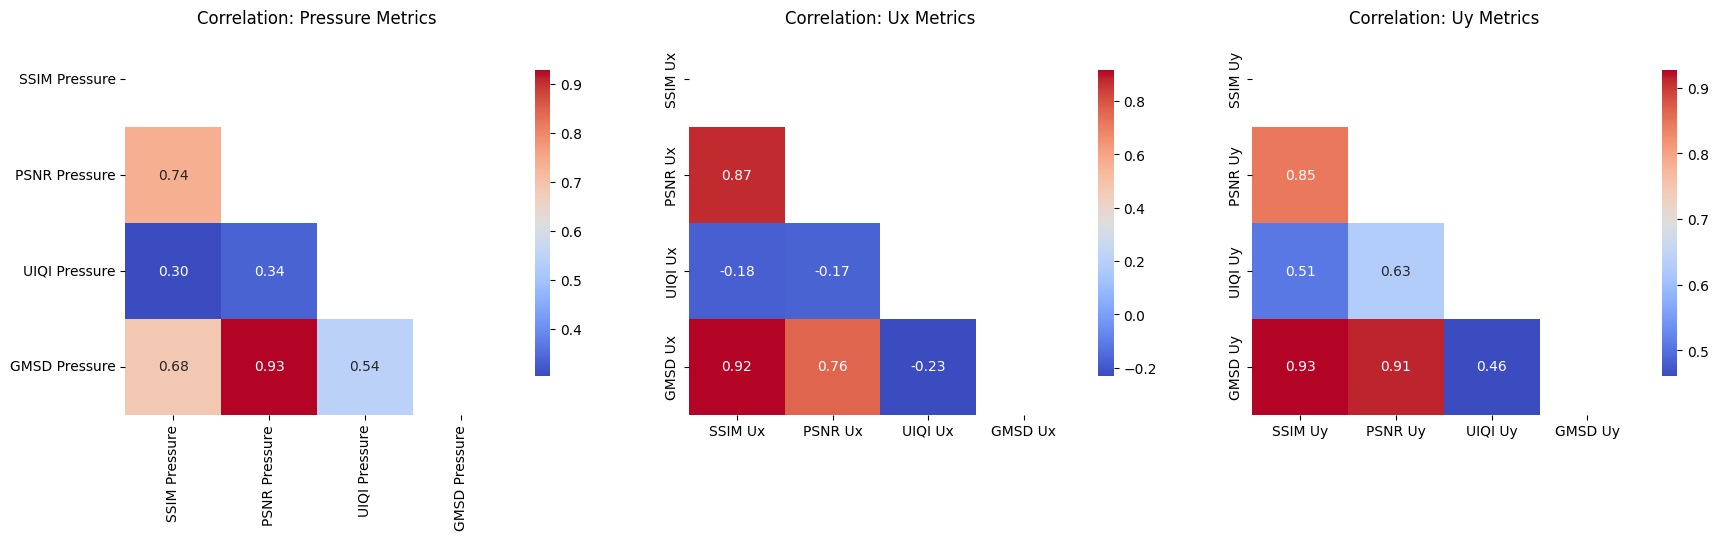

In [51]:
# lets show correlation map between the metrics
import seaborn as sns
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Pressure
sns.heatmap(results_df_p.corr(), annot=True, cmap='coolwarm', fmt='.2f', 
            square=True, cbar_kws={"shrink": .8}, 
            mask=np.triu(np.ones_like(results_df_p.corr(), dtype=bool)), ax=axes[0])
axes[0].set_title('Correlation: Pressure Metrics')

# Ux
sns.heatmap(results_df_ux.corr(), annot=True, cmap='coolwarm', fmt='.2f', 
            square=True, cbar_kws={"shrink": .8}, 
            mask=np.triu(np.ones_like(results_df_ux.corr(), dtype=bool)), ax=axes[1])
axes[1].set_title('Correlation: Ux Metrics')

# Uy
sns.heatmap(results_df_uy.corr(), annot=True, cmap='coolwarm', fmt='.2f', 
            square=True, cbar_kws={"shrink": .8}, 
            mask=np.triu(np.ones_like(results_df_uy.corr(), dtype=bool)), ax=axes[2])
axes[2].set_title('Correlation: Uy Metrics')

plt.tight_layout()
plt.show()